# Test of pointfusion gradslam algorithm with monodepth2

In [1]:
from argparse import ArgumentParser, RawTextHelpFormatter

import open3d as o3d
import torch
from torch.utils.data import DataLoader

from gradslam.datasets.icl import ICL
from gradslam.datasets.tum import TUM
from end2endslam.dataloader.kitti import KITTI
from gradslam.slam.pointfusion import PointFusion
from gradslam.structures.rgbdimages import RGBDImages
from end2endslam.loss_hamza.reprojection_loss import get_indexed_projection_TUM, image2image
from perception.monodepth2.monodepthwrapper import MonoDepthv2Wrapper
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image as pil_image
import numpy as np
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import imageio
import os

In [2]:
from matplotlib import pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
DATASET = "kitti"
DATASET_PATH = "C:\\Users\\david\\Projects\\data\\kitti\\data_odometry\\dataset"
SEQUENCES_PATH = "C:\\Users\\david\\Projects\\data\\kitti\\data_odometry\\dataset\\sequences.txt"
ODOMETRY = "gt"

In [5]:
def pointfusion_test(dataset_name,dataset_path,odometry="gradicp",sequences=None,visualize=True):
    """ test pointfusion with monodepth 2
    
    Args:
        dataset_name (str): Dataset to use. Supported options ["icl", "tum", "kitti"]
        dataset_path (str): path to dataset directory
        odometry (str): Odometry method to use. Supported options: ["gt", "icp", "gradicp"]
                     gt = Ground Truth odometry, icp = Iterative Closest Point
                     gradicp (*default) = Differentiable Iterative Closest Point
                     
        sequences (str): Path to .txt file containing sequences. 
                        If it doesn't work for TUM, leave option out, it then takes all sequences in dataset_path
        
    """

In [6]:
def change_res(input, new_res, interpol = "bicubic"):
    bsize, ssize, height, width, csize = input.size(0), input.size(1), input.size(2), input.size(3), input.size(4)
    input = input.view([bsize*ssize, height, width, csize]).permute(0, 3, 1, 2)
    input = torch.nn.functional.interpolate(input = input, size = new_res, mode = interpol)
    input = input.permute(0, 2, 3, 1).view([bsize, ssize, new_res[0], new_res[1], csize])
    return input

In [7]:
def pose_loss(gt, pred, device):
    gt = gt.to(device)
    pred = pred.to(device)
    T_gt = gt[:, :, :3, -1:].view([-1, 3])
    T_pred = pred[:, :, :3, -1:].view([-1, 3])
    R_gt = gt[:, :, :3, :3].view([-1, 3, 3])
    R_pred = pred[:, :, :3, :3].view([-1, 3, 3])

    T_error = torch.square(T_gt - T_pred).sum([-1])
    R_ = torch.eye(3).view([1, 3, 3]).to(device) - torch.matmul(torch.transpose(R_gt, 1, 2), R_pred)
    R_error = torch.tensor([torch.trace(i) for i in R_], device=device)
    loss = torch.sqrt(T_error + 2 * torch.abs(R_error) /3)
    return loss

# FIRST POINTFUSION TEST

In [236]:
dataset_name = DATASET
dataset_path = DATASET_PATH
sequences = SEQUENCES_PATH
odometry = ODOMETRY
visualize = True

In [237]:
# enforce parameters
assert(dataset_name in ["icl", "tum", "kitti"])
assert(odometry in ["gt", "icp", "gradicp"])

# select device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

DepthPredictor = MonoDepthv2Wrapper( device)

optim = Adam(DepthPredictor.parameters(), lr = 1e-6)

# load dataset
if dataset_name == "icl":
    dataset = ICL(dataset_path, seqlen=10, height=192, width=640)
elif dataset_name == "tum":
    dataset = TUM(dataset_path, seqlen=10, height=192, width=640, sequences=sequences)
elif dataset_name == "kitti":
    dataset = KITTI(dataset_path, seqlen=10, height=192, width=640, sequences=sequences)

loader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)

writer = SummaryWriter()

-> Loading model from  depth/monodepth2/models\mono+stereo_640x192
   Loading pretrained encoder
   Loading pretrained decoder


In [291]:
loader = DataLoader(dataset=dataset, batch_size=8, shuffle=False)

In [292]:
(colors, depths, intrinsics, poses, *_) = next(iter(loader))

In [293]:
colors.shape

torch.Size([8, 10, 192, 640, 3])

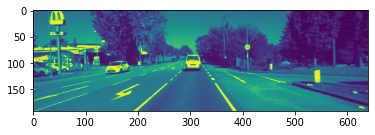

In [294]:
plt.imshow(colors[0,0,:,:,0].numpy())

In [295]:
colors = colors.to(device)
# Todo: clean since kitti has no gt depth
if dataset_name == "tum":
    depths = depths.to(device)
intrinsics = intrinsics.to(device)
poses = poses.to(device)

In [255]:
# Hard coded
batch_loss = 0
pred_depths = []
for pred_index in range(10):
    print("Predicting depth for frame ",pred_index)
    DepthPredictor.zero_grad()
    input_dict = {"device": device}
    input_dict["rgb"] = (colors[:, pred_index, ::] / 255.0).permute(0, 3, 1, 2)
    input_dict["rgb_ref"] = (colors[:, pred_index - 1, ::] / 255.0).permute(0, 3, 1, 2)
    input_dict["pose"] = torch.matmul(torch.inverse(poses[:, pred_index - 1, ::]), poses[:, pred_index, ::])
    # Todo: clean
    if dataset_name == "tum":
        input_dict["depth"] = depths[:, pred_index, ::].permute(0, 3, 1, 2)
    else:
        input_dict["depth"] = None
    input_dict["intrinsic"] = intrinsics

    if pred_index == 0:
        #Todo: clean, KITTI does not provide GT depth
        if dataset_name == "kitti":
            depth_predictions, loss = DepthPredictor.pred_loss_reproj(input_dict)
        else:
            depth_predictions, loss = DepthPredictor.pred_loss_depth(input_dict)
    elif pred_index > 0:
        depth_predictions, loss = DepthPredictor.pred_loss_reproj(input_dict)
        batch_loss += loss.item() * 0.1
        loss.backward()
        optim.step()
        writer.add_scalar("Depth/Perstep_loss", loss.item(), counter["every"])
        counter["every"] +=1

    pred_depths.append(depth_predictions.permute(0, 2, 3, 1).unsqueeze(1))


Predicting depth for frame  0


C:\Users\david\anaconda3\envs\gradslam\lib\site-packages\torch\nn\functional.py:3825: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.



Predicting depth for frame  1
Predicting depth for frame  2
Predicting depth for frame  3
Predicting depth for frame  4
Predicting depth for frame  5
Predicting depth for frame  6
Predicting depth for frame  7
Predicting depth for frame  8
Predicting depth for frame  9


In [302]:
(colors, depths, intrinsics, poses, *_) = next(iter(loader))

In [303]:
from perception.monodepth2.layers import disp_to_depth

batch_loss = 0
pred_depths = []
for pred_index in range(10):
    print("Predicting depth for frame ",pred_index)
    #DepthPredictor.zero_grad()
    input_dict = {"device": device}
    input_dict["rgb"] = (colors[:, pred_index, ::] / 255.0).permute(0, 3, 1, 2)
    #input_dict["rgb_ref"] = (colors[:, pred_index - 1, ::] / 255.0).permute(0, 3, 1, 2)
    #input_dict["pose"] = torch.matmul(torch.inverse(poses[:, pred_index - 1, ::]), poses[:, pred_index, ::])
    # Todo: clean
    #if dataset_name == "tum":
    #    input_dict["depth"] = depths[:, pred_index, ::].permute(0, 3, 1, 2)
    #else:
    #    input_dict["depth"] = None
    #input_dict["intrinsic"] = intrinsics

    with torch.no_grad():
        features = DepthPredictor.encoder(input_dict["rgb"])
        outputs = DepthPredictor.depth_decoder(features)

    disp_predictions = outputs[("disp", 0)]
    
    scaled_disp, depth_predictions = disp_to_depth(disp_predictions, 0.1, 100)
    
    #depth_predictions = disp_predictions

    pred_depths.append(depth_predictions.permute(0, 2, 3, 1).unsqueeze(1))


Predicting depth for frame  0
Predicting depth for frame  1
Predicting depth for frame  2
Predicting depth for frame  3
Predicting depth for frame  4
Predicting depth for frame  5
Predicting depth for frame  6
Predicting depth for frame  7
Predicting depth for frame  8
Predicting depth for frame  9


In [304]:
writer.add_scalar("Depth/Batchwise_loss", batch_loss, counter["batch"] )
losses.append(batch_loss)
counter["batch"] +=1

pred_depths = torch.cat(pred_depths, dim= 1)
# projection = get_indexed_projection_TUM(proj_from_index = 1, proj_to_index=0, rgbs = colors, depths = depths, intrinsic = intrinsics, poses = poses, device = device)

colors = change_res(colors, (120, 160), interpol="bicubic")
pred_depths = change_res(pred_depths,(120, 160), interpol="nearest")

intrinsics[:, :, 0, :] = intrinsics[:, :, 0, :] * 160 / 640
intrinsics[:, :, 1, :] = intrinsics[:, :, 1, :] * 120 / 192

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


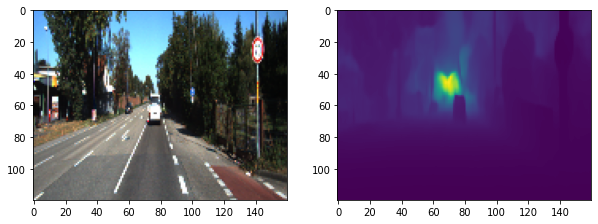

In [305]:
batch_id = 1
frame_id = 0

plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
ax.imshow(colors[batch_id,frame_id,:,:,:].detach().numpy().astype(np.uint))
ax = plt.subplot(1,2,2)
#ax.imshow(pred_depths[batch_id,frame_id+9,:,:,0].detach().numpy())
ax.imshow(pred_depths[batch_id,frame_id,:,:,0].detach().numpy())


In [316]:
batch_idx = 0

print("Getting pose loss")

# With predicted depth
#rgbdimages = RGBDImages(colors, pred_depths, intrinsics, poses, channels_first=False, device=torch.device("cpu"))
n_frames = 9
rgbdimages = RGBDImages(colors[0:1,0:n_frames], pred_depths[0:1,0:n_frames], intrinsics[0:1,0:n_frames], poses[0:1,0:n_frames], channels_first=False, device=torch.device("cpu"))

# without poses
#rgbdimages = RGBDImages(colors, pred_depths, intrinsics, channels_first=False, device=torch.device("cpu"))

odometry_test = 'icp'
slam = PointFusion(odom = odometry_test,dsratio=4, device=torch.device("cpu"))
pointclouds, recovered_poses = slam(rgbdimages)
# loss_p = pose_loss(poses, recovered_poses, device)
# writer.add_scalar("Pose/Batchwise_loss_pred", loss_p.mean().item(), counter["detailed"] )


Getting pose loss


In [317]:
# Visualize (images stored in vis directory)
if visualize:
    if not os.path.exists("vis"):
        os.makedirs("vis")
    # SLAM Visualization
    o3d.visualization.draw_geometries([pointclouds.open3d(0)])
    
    
    # Color Visualization
    #vis_color = colors[0, 0, :, :, :].detach().cpu().numpy()
    #imageio.imwrite("vis/test_{}_{}_color.png".format(dataset_name, batch_idx), vis_color)
    
    # Depth Visualization
    #vis_pred_depth = pred_depths[0, 0, :, :, :].detach().cpu().numpy()
    #vmax = np.percentile(vis_pred_depth, 95)
    #vmin = vis_pred_depth.min()
    #normalizer = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
    #pred_depth_np = (mapper.to_rgba(vis_pred_depth[:, :, 0])[:, :, :3] * 255).astype(np.uint8)
    #imageio.imwrite("vis/test_{}_{}_depth.png".format(dataset_name, batch_idx), pred_depth_np)

counter["detailed"] += 1

In [289]:
pointclouds.plotly(0, max_num_points=15000).update_layout(autosize=False, width=600).show()

In [211]:
epochs = 1
losses = []
counter = {"every": 0, "batch": 0, "detailed": 0}
for e_idx in range(epochs):
    for batch_idx, (colors, depths, intrinsics, poses, *_) in enumerate(loader):
        colors = colors.to(device)
        # Todo: clean since kitti has no gt depth
        if dataset_name == "tum":
            depths = depths.to(device)
        intrinsics = intrinsics.to(device)
        poses = poses.to(device)

        # Hard coded
        batch_loss = 0
        pred_depths = []
        for pred_index in range(10):
            DepthPredictor.zero_grad()
            input_dict = {"device": device}
            input_dict["rgb"] = (colors[:, pred_index, ::] / 255.0).permute(0, 3, 1, 2)
            input_dict["rgb_ref"] = (colors[:, pred_index - 1, ::] / 255.0).permute(0, 3, 1, 2)
            input_dict["pose"] = torch.matmul(torch.inverse(poses[:, pred_index - 1, ::]), poses[:, pred_index, ::])
            # Todo: clean
            if dataset_name == "tum":
                input_dict["depth"] = depths[:, pred_index, ::].permute(0, 3, 1, 2)
            else:
                input_dict["depth"] = None
            input_dict["intrinsic"] = intrinsics

            if pred_index == 0:
                #Todo: clean, KITTI does not provide GT depth
                if dataset_name == "kitti":
                    depth_predictions, loss = DepthPredictor.pred_loss_reproj(input_dict)
                else:
                    depth_predictions, loss = DepthPredictor.pred_loss_depth(input_dict)
            elif pred_index > 0:
                depth_predictions, loss = DepthPredictor.pred_loss_reproj(input_dict)
                batch_loss += loss.item() * 0.1
                loss.backward()
                optim.step()
                writer.add_scalar("Depth/Perstep_loss", loss.item(), counter["every"])
                counter["every"] +=1

            pred_depths.append(depth_predictions.permute(0, 2, 3, 1).unsqueeze(1))


        writer.add_scalar("Depth/Batchwise_loss", batch_loss, counter["batch"] )
        losses.append(batch_loss)
        counter["batch"] +=1

        pred_depths = torch.cat(pred_depths, dim= 1)
        # projection = get_indexed_projection_TUM(proj_from_index = 1, proj_to_index=0, rgbs = colors, depths = depths, intrinsic = intrinsics, poses = poses, device = device)

        colors = change_res(colors, (120, 160), interpol="bicubic")
        pred_depths = change_res(pred_depths,(120, 160), interpol="nearest")

        intrinsics[:, :, 0, :] = intrinsics[:, :, 0, :] * 160 / 640
        intrinsics[:, :, 1, :] = intrinsics[:, :, 1, :] * 120 / 192

        # SLAM

        if batch_idx ==0 or batch_idx % 10 == 0:
            print("Getting pose loss")

            # With predicted depth
            rgbdimages = RGBDImages(colors, pred_depths, intrinsics, poses, channels_first=False, device=torch.device("cpu"))
            slam = PointFusion(odom=odometry, dsratio=4, device=torch.device("cpu"))
            pointclouds, recovered_poses = slam(rgbdimages)
            loss_p = pose_loss(poses, recovered_poses, device)
            writer.add_scalar("Pose/Batchwise_loss_pred", loss_p.mean().item(), counter["detailed"] )

            # Visualize (images stored in vis directory)
            if visualize:
                if not os.path.exists("vis"):
                    os.makedirs("vis")
                # SLAM Visualization
                o3d.visualization.draw_geometries([pointclouds.open3d(0)])
                # Color Visualization
                vis_color = colors[0, 0, :, :, :].detach().cpu().numpy()
                imageio.imwrite("vis/test_{}_{}_color.png".format(dataset_name, batch_idx), vis_color)
                # Depth Visualization
                vis_pred_depth = pred_depths[0, 0, :, :, :].detach().cpu().numpy()
                vmax = np.percentile(vis_pred_depth, 95)
                vmin = vis_pred_depth.min()
                normalizer = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
                mapper = cm.ScalarMappable(norm=normalizer, cmap='magma')
                pred_depth_np = (mapper.to_rgba(vis_pred_depth[:, :, 0])[:, :, :3] * 255).astype(np.uint8)
                imageio.imwrite("vis/test_{}_{}_depth.png".format(dataset_name, batch_idx), pred_depth_np)

            # With ground truth depth
            if dataset_name == "tum":
                depths = change_res(depths,(120, 160), interpol="nearest")
                rgbdimages = RGBDImages(colors, depths, intrinsics, poses, channels_first=False, device=torch.device("cpu"))
                slam = PointFusion(odom=odometry, dsratio=4, device=torch.device("cpu"))
                pointclouds, recovered_poses = slam(rgbdimages)
                loss_p = pose_loss(poses, recovered_poses, device)
                writer.add_scalar("Pose/Batchwise_loss_gt", loss_p.mean().item(), counter["detailed"] )

            counter["detailed"] += 1


        print("loss: {}".format(sum(losses[-5:])/ 5))

Getting pose loss


RuntimeError: [Open3D ERROR] GLFW Error: WGL: Failed to make context current: The handle is invalid. 